In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
from imblearn.over_sampling import SMOTE
import nltk.data

In [2]:
# read the dataset
reviews_data = pd.read_json(r"C:\Users\user\Documents\UoM\Thesis\data\Clothing_Shoes_and_Jewelry_5.json", lines=True)

# Keep only the review text and the grade
reviews_data = reviews_data[['overall', 'reviewText']]

# Drop the products whose values are null
reviews_data = reviews_data[reviews_data['reviewText'].notna()]

ratings = []
for index,entry in enumerate(reviews_data['overall']):
    if entry == 1.0 or entry == 2.0:
        ratings.append(-1)
    elif entry == 3.0:
        ratings.append(0)
    elif entry == 4.0 or entry == 5.0:
        ratings.append(1)

In [3]:
""""
Split each review into sentences
and preprocess each sentence
"""
sentenceEnders = re.compile('[.!?]')

stopwords = stopwords.words('english')
stopwords.remove('not')
stopwords.extend(['wear', 'shoes', 'size', 'fit', 'look', 'good'])

preprocessed_data = []
index = 0
for review in reviews_data['reviewText']:
    if ((index % 10000) == 0):
        print(str(round((index/len(reviews_data)*100))) + "% of the total reviews have been preprocessed")   
    review_sentences = sentenceEnders.split(review)
    for sentence in review_sentences:
        sentence = sentence.lower()
        sentence = re.sub(r'not a *', 'not',sentence)
        sentence = re.sub(r'not *', 'not',sentence) 
        sentence = re.sub(r"\w+n't ", 'not',sentence) 
        sentence = word_tokenize(sentence)
        sentence = [word for word in sentence if not word in stopwords]
        sentence = ' '.join(sentence)
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        if(sentence != ''):
            review = {}
            review["index"] = index
            review["sentence"] = sentence
            review["rating"] = ratings[index]
            preprocessed_data.append(review)
    index += 1
print("100% of the total reviews have been preprocessed")

0% of the total reviews have been preprocessed
4% of the total reviews have been preprocessed
7% of the total reviews have been preprocessed
11% of the total reviews have been preprocessed
14% of the total reviews have been preprocessed
18% of the total reviews have been preprocessed
22% of the total reviews have been preprocessed
25% of the total reviews have been preprocessed
29% of the total reviews have been preprocessed
32% of the total reviews have been preprocessed
36% of the total reviews have been preprocessed
39% of the total reviews have been preprocessed
43% of the total reviews have been preprocessed
47% of the total reviews have been preprocessed
50% of the total reviews have been preprocessed
54% of the total reviews have been preprocessed
57% of the total reviews have been preprocessed
61% of the total reviews have been preprocessed
65% of the total reviews have been preprocessed
68% of the total reviews have been preprocessed
72% of the total reviews have been preproce

In [4]:
print("Before preprocessing: ", reviews_data['reviewText'][5])
print("------------------------------------------------")
print("After preprocessing: ", [d for d in preprocessed_data if d['index'] == 5])
print(len(preprocessed_data))

Before preprocessing:  I received this today and I'm not a fan of it but my daughter is I thought it would be puffier as it looks in the pic but it's not and the one they sent me is pink underneath and the waist band is pink which is not what I wanted due to the fact she already had the sandals she was gonna wear with it now I gotta find another pair of sandals,ima just keep it cuz she likes it.
------------------------------------------------
After preprocessing:  [{'index': 5, 'sentence': 'received today  m notfan daughter thought would puffier looks pic  s notnd one sent pink underneath waist band pink notwhat wanted due fact already sandals gon na got ta find another pair sandals   ima keep cuz likes', 'rating': 1}]
1317681


In [5]:
# Split Dataset into training and test
indexes = [i for i in range(len(reviews_data))]

Train_X_index, Test_X_index, Train_Y_review, Test_Y_review = model_selection.train_test_split(indexes,ratings,test_size=0.3)

df = pd.DataFrame(preprocessed_data)

train = df[df['index'].isin(Train_X_index)]
Train_Y = train['rating'].tolist()
Train_X = train['sentence'].tolist()
Train_index = train['index'].tolist()


test = df[df['index'].isin(Test_X_index)]
Test_Y = test['rating'].tolist()
Test_X = test['sentence'].tolist()
Test_index = test['index'].tolist()

all_sentences = Train_X + Test_X

In [7]:
# Word Vectorization
        
TfIdf_vect = TfidfVectorizer(max_features=10000)
TfIdf_vect.fit(all_sentences)
Train_X_TfIdf = TfIdf_vect.transform(Train_X)
Test_X_TfIdf = TfIdf_vect.transform(Test_X)

In [8]:
# Oversampling 
oversample = SMOTE(random_state=100)
X_SMOTE, y_SMOTE = oversample.fit_resample(Train_X_TfIdf, Train_Y)

In [9]:
def find_Max_Element(scores):
    c = Counter(scores)
    negatives = c[-1]
    neutral = c[0]
    positives = c[1]
    
    if(scores[0] == -1):
        negatives += 1
    elif(scores[0] == 0):
        neutral += 1
    elif(scores[0] == 1):
        positives += 1
    
    if(scores[-1] == -1):
        negatives += 1
    elif(scores[-1] == 0):
        neutral += 1
    elif(scores[-1] == 1):
        positives += 1

    if(neutral == positives and neutral > negatives and positives > negatives):
        max_element = 1
    elif (neutral == negatives and neutral > positives and negatives > positives):
        max_element = -1
    elif (neutral == negatives and negatives == positives):
        max_element = 0
    elif (positives == negatives and positives > neutral and negatives > neutral) :
        max_element = 0
    else:
        max_element = max(set(scores), key = scores.count)
        
    return max_element


-10
Accuracy:  74.93480393329665
--------------------------
              precision    recall  f1-score   support

    Negative       0.50      0.60      0.55      8109
     Neutral       0.26      0.47      0.33      9153
    Positive       0.93      0.81      0.87     66332

    accuracy                           0.75     83594
   macro avg       0.56      0.63      0.58     83594
weighted avg       0.82      0.75      0.78     83594



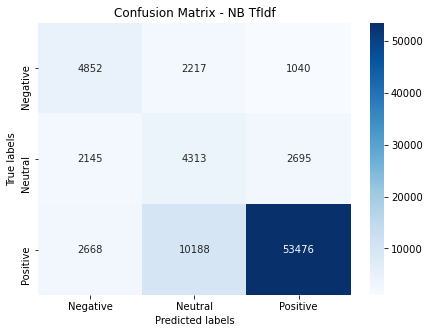

In [10]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_SMOTE, y_SMOTE)

# predict the labels on validation dataset
predictions_NB_sentences = Naive.predict(Test_X_TfIdf)

# Get grades by review
predicted_scores_frame = pd.DataFrame(np.column_stack([Test_index, predictions_NB_sentences, Test_Y]), 
                               columns=['review Index', 'prediction', 'actual'])

print(len(predicted_scores_frame['review Index'].unique()) - len(Test_Y_review))

# for each review get all scores by review
scores_by_review_frame = predicted_scores_frame.groupby('review Index')['prediction'].apply(list)
majority_scores =  scores_by_review_frame.apply(find_Max_Element)
predicted_scores = list(majority_scores)

# for each review get its actual score
actual_scores_frame = predicted_scores_frame.groupby('review Index')['actual'].first()
actual_scores = list(actual_scores_frame)

# Calculate Accuracy
accuracy = accuracy_score(predicted_scores, actual_scores)*100
print("Accuracy: ", accuracy)
print("--------------------------")

# Confusion Matrix
cm = confusion_matrix(actual_scores, predicted_scores)
plt.figure(figsize = (7,5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',ax=ax)
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - NB TfIdf'); 
ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']); 
ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']);

# Classification Report
my_tags = ['Negative','Neutral','Positive']
print(classification_report(actual_scores, predicted_scores, target_names=my_tags))
report = classification_report(actual_scores, predicted_scores, target_names=my_tags, output_dict=True);
clsf_report = pd.DataFrame(report).transpose()
clsf_report.to_csv('reports/NaiveBayes_TfIdf.csv', index= True)

-10
Accuracy:  79.00088523099744
              precision    recall  f1-score   support

    Negative       0.55      0.54      0.55      8109
     Neutral       0.28      0.32      0.30      9153
    Positive       0.90      0.89      0.89     66332

    accuracy                           0.79     83594
   macro avg       0.58      0.58      0.58     83594
weighted avg       0.80      0.79      0.79     83594



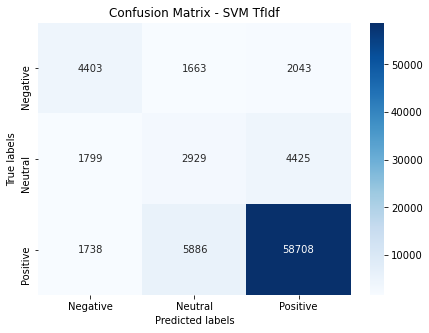

In [11]:
# Support Vector Machine with linear cernel

from sklearn.svm import LinearSVC
import timeit

# Train the classifier
clf = LinearSVC(random_state=5, tol=1e-5)
clf.fit(X_SMOTE, y_SMOTE)

# predict on the test data
predictions_SVM = clf.predict(Test_X_TfIdf)

# Get grades by review
predicted_scores_frame = pd.DataFrame(np.column_stack([Test_index, predictions_SVM, Test_Y]), 
                               columns=['review Index', 'prediction', 'actual'])

print(len(predicted_scores_frame['review Index'].unique()) - len(Test_Y_review))

# for each review get all scores by review
scores_by_review_frame = predicted_scores_frame.groupby('review Index')['prediction'].apply(list)
majority_scores =  scores_by_review_frame.apply(find_Max_Element)
predicted_scores = list(majority_scores)

# for each review get its actual score
actual_scores_frame = predicted_scores_frame.groupby('review Index')['actual'].first()
actual_scores = list(actual_scores_frame)

# Calculate Accuracy
accuracy = accuracy_score(predicted_scores, actual_scores)*100
print("Accuracy: ", accuracy)

# Confusion Matrix
cm = confusion_matrix(actual_scores, predicted_scores)
plt.figure(figsize = (7,5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',ax=ax)
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - SVM TfIdf'); 
ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']); 
ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']);

# Classification Report
my_tags = ['Negative','Neutral','Positive']
print(classification_report(actual_scores, predicted_scores, target_names=my_tags))
report = classification_report(actual_scores, predicted_scores, target_names=my_tags, output_dict=True);
clsf_report = pd.DataFrame(report).transpose()
clsf_report.to_csv('reports/SVM_TfIdf.csv', index= True)